# Project code for predicting student categories (based on results)

Contributors: Helena Sokk and Kristiina Oksner

## Working with the data

In this part we focus on gathering and cleaning the data. Our goal is to combine all available data into one dataset to later use it during training and testing our chosen model.

In [1]:
# imports
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/Colab Notebooks/ML/Project")

Mounted at /content/drive


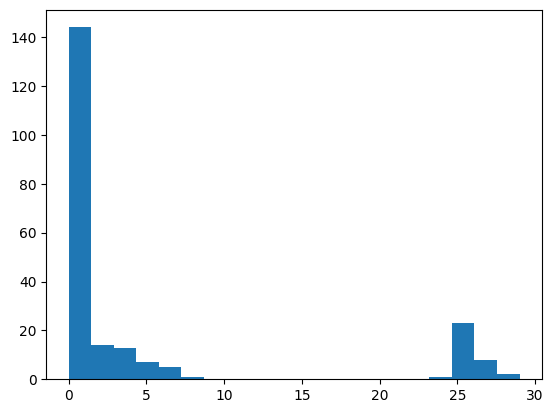

In [ ]:
import matplotlib.pyplot as plt

plt.hist(results, bins=20)

plt.show()
#this plot shows the number of unsolved tests, if 20 zeros then probably students who made the first exam

In [2]:
import pandas as pd
import numpy as np
# Loading the data

data = pd.read_csv ('data.csv')
log = pd.read_csv ('log.csv')
data_v = pd.read_csv('data-2021.csv')
log_v = pd.read_csv('log-2021.csv')

In [3]:
n=501
# Replacing student IDs so that we don't have duplicates
# We have two different years
for i in range(len(data_v['Student'])):
    new="S"+str(n)
    old=data_v.iloc[i]['Student']
    data_v['Student'] = data_v['Student'].replace([old], new)
    log_v = log_v.replace(old,new)
    #print(df_2021.iloc[i]['Student'])
    n+=1

In [4]:
# Function to modify log files
def log_mod(log,columns):
  ##Parameters: log - log file, columns - column names
    day=8
    log=log.drop(log[(log['Activity'] == 'Week 1 quiz') & (log['Day'] > day)].index)
    log=log.drop(log[(log['Activity'] == 'Week 1 quiz') & (log['Day'] == day) & (log['Time'] > '00:00')].index)
    log=log.drop(log[(log['Activity'] == 'Week 1 homework') & (log['Day'] > day)].index)
    log=log.drop(log[(log['Activity'] == 'Week 1 homework') & (log['Day'] == day) & (log['Time'] > '00:00')].index)
    day=11
    # In this part we remove all of the tests and homeworks that were done after the deadline
    for i in range(2,17):
        homework = 'Week '+str(i)+' homework'
        quiz='Week '+str(i)+' quiz'
        day += 7
        if quiz in columns:
            log=log.drop(log[(log['Activity'] == quiz) & (log['Day'] > day)].index)
            log=log.drop(log[(log['Activity'] == quiz) & (log['Day'] == day) & (log['Time'] > '08:00')].index)
        if homework in columns:
            log=log.drop(log[(log['Activity'] == homework) & (log['Day'] > day)].index)
            log=log.drop(log[(log['Activity'] == homework) & (log['Day'] == day) & (log['Time'] > '08:00')].index)
    log.drop(log[log['Score'] == '-'].index, inplace=True)
    log = log.reset_index().groupby(['Student', 'Activity'])['Score'].aggregate('max').unstack()
    log.fillna(value=0, inplace=True)
    # Replace columns names to avoid duplicates
    log = log.rename(columns={'Week 1 homework': 'Week 1 homework score', 'Week 1 quiz': 'Week 1 quiz score',
                        'Week 10 homework': 'Week 10 homework score', 'Week 10 quiz': 'Week 10 quiz score',
           'Week 11 homework': 'Week 11 homework score', 'Week 11 quiz': 'Week 11 quiz score',
                        'Week 12 quiz': 'Week 12 quiz score', 'Week 13 homework': 'Week 13 homework score',
           'Week 13 quiz': 'Week 13 quiz score', 'Week 14 homework': 'Week 14 homework score',
                        'Week 14 quiz': 'Week 14 quiz score', 'Week 15 homework': 'Week 15 homework score',
           'Week 15 quiz': 'Week 15 quiz score', 'Week 16 quiz': 'Week 16 quiz score', 'Week 2 homework': 'Week 2 homework score',
                        'Week 2 quiz': 'Week 2 quiz score', 'Week 3 homework': 'Week 3 homework score',
                        'Week 3 quiz': 'Week 3 quiz score', 'Week 4 homework': 'Week 4 homework score', 'Week 4 quiz': 'Week 4 quiz score',
           'Week 5 homework': 'Week 5 homework score', 'Week 5 quiz': 'Week 5 quiz score', 'Week 6 quiz': 'Week 6 quiz score',
                        'Week 7 homework': 'Week 7 homework score', 'Week 7 quiz': 'Week 7 quiz score', 'Week 8 homework': 'Week 8 homework score',
                        'Week 8 quiz': 'Week 8 quiz score', 'Week 9 homework': 'Week 9 homework score', 'Week 9 quiz': 'Week 9 quiz score'})
    log = log.reset_index()
    # returns modified log file
    return log

In [5]:
# Function to modify data files
def data_mod(data,log):
  ##Parameters: data - data file, log - log file
  # We count all unsolved tests and homeworks so that we could drop them (people who did the exam)
    data['sum_0'] = data[data == 0].count(axis=1)
    data = data.drop(data[(data['sum_0'] > 20) & (data['Grade'] == 'A')].index)
    data = data.drop(data[(data['Score'] == '-')].index)
    # We divide all students into 3 categories
    conditions = [
        (data['Score'].astype(float) > 65),
        (data['Score'].astype(float) > 35) & (data['Score'].astype(float) <= 65),
        (data['Score'].astype(float) <= 35)
    ]
    values = [1, 2, 3]
    data['Category'] = np.select(conditions, values)
    # Making sure that students in data and log files match
    for student in data.Student:
        if student not in list(log.Student):
            data = data.drop(data[data.Student == student].index)
    # Returns modified version of data file
    return data

In [6]:
# File modifications and combining data and log files
log=log_mod(log, log.columns)
log_v=log_mod(log_v, data_v.columns)
data=data_mod(data,log)
data_v= data_mod(data_v,log_v)
frames1 = [data, data_v]

data_comb = pd.concat(frames1)

frames2 = [log, log_v]

log_comb = pd.concat(frames2)

In [7]:
data_comb.loc[data_comb['Skill level']=='-'] # Some students didn't answer the questionnaire (skill level is missing)

,Student,Gender,Skill level,Week 1 quiz,Week 2 quiz,Week 3 quiz,Week 4 quiz,Week 5 quiz,Week 6 quiz,Week 7 quiz,...,Week 9 homework,Week 10 homework,Week 11 homework,Week 13 homework,Week 14 homework,Week 15 homework,Score,Grade,sum_0,Category
25,S026,F,-,6,3,1,1,1,1,1,...,1,1,1,0,0,1,68.9,D,2,1
55,S056,M,-,1,2,1,1,1,1,1,...,0,1,1,3,0,0,67.33,D,6,1
57,S058,M,-,0,1,1,1,1,4,1,...,4,4,0,6,0,0,89.26,B,6,1
66,S067,M,-,4,1,2,3,1,1,1,...,0,1,2,0,4,1,79.2,C,4,1
70,S071,M,-,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1.86,F,27,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314,S815,M,-,1,3,1,3,2,3,1,...,13,7,3,9,2,13,76.03,C,0,1
317,S818,M,-,1,1,2,1,0,2,1,...,0,0,1,3,1,0,66.99,D,5,1
341,S842,M,-,2,3,4,7,3,3,1,...,5,2,1,11,2,15,100,A,0,1
351,S852,F,-,0,0,4,1,0,0,0,...,0,0,0,0,0,0,0.31,F,27,3


In [8]:
# Skill level analysis: how many missing, what is the distribution and what should we use?
levels = data_comb['Skill level'].unique()
counts = []
for level in levels:
  counts.append(len(data_comb.loc[data_comb['Skill level']==level]))
print(counts, levels)

[121, 239, 30, 230, 85, 75] ['Novice' 'Proficient' 'Expert' 'Intermediate' 'Beginner' '-']


In [9]:
# Coverting skill levels into separate columns so that we could use them for prediction
levels = data_comb['Skill level'].unique()
data_comb['Skill level'] = data_comb['Skill level'].replace('-', levels[0])
dummies = pd.get_dummies(data_comb['Skill level'])
data_comb = pd.concat([data_comb, dummies], axis='columns')
data_comb = data_comb.drop(['Skill level'], axis='columns')

In [10]:
# Some extra work to be 100% sure that both files have the same amount of rows
print(len(log_comb))
print(len(data_comb))
for student in list(log_comb['Student']):
  if student not in list(data_comb['Student']):
    log_comb = log_comb.loc[log_comb['Student']!=student]
    log_comb = log_comb.reset_index(drop=True)
print(len(log_comb))

833
780
780


In [11]:
# Final combination
#all_comb = pd.concat([log_comb, data_comb], ignore_index=True)
all_comb = log_comb.merge(data_comb, on='Student')

In [12]:
data = all_comb.drop(['Category', 'Student', 'Grade', 'Gender'], axis = 'columns')
target = all_comb[['Category']]

## Model training

We chose different models to compare the results. For comparison we used accuracy scores and confusion matrix.

In [21]:
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
tl = TomekLinks()
train_X, test_X, train_y, test_y = train_test_split(data[['Week 1 homework', 'Week 1 quiz', 'Week 2 homework', 'Week 2 quiz',
                                                                      'Week 3 homework', 'Week 3 quiz', 'Week 4 homework', 'Week 4 quiz',
                                                              'Week 1 homework score', 'Week 1 quiz score', 'Week 2 homework score', 'Week 2 quiz score',
                                                                      'Week 3 homework score', 'Week 3 quiz score', 'Week 4 homework score', 'Week 4 quiz score',
                                                          'Week 5 homework', 'Week 5 quiz', 'Week 6 quiz', 'Week 5 homework score', 'Week 5 quiz score', 'Week 6 quiz score',
                                                              'Beginner', 'Expert', 'Intermediate', 'Novice', 'Proficient']], target, test_size=0.3)
# Train-test splitting

array([[<Axes: title={'center': 'Category'}>]], dtype=object)

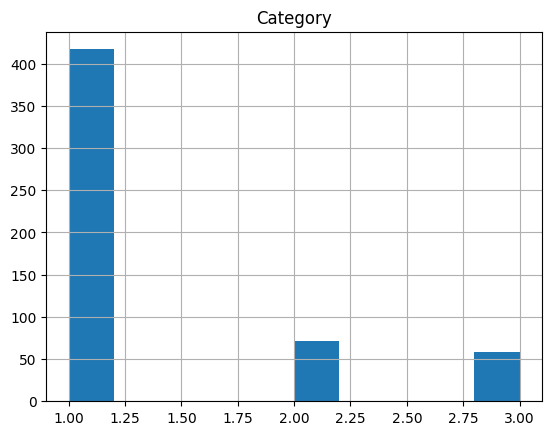

In [22]:
train_y.hist() # The data is extremely unbalanced

In [23]:
X_train, y_train = tl.fit_resample(train_X, train_y)

train_X, train_y = SMOTE().fit_resample(X_train, y_train)
# Using over- and undersampling to make it more balanced

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

'''
In this part we tried many different models to predict student categories:
Stacking classifier,
GradientBoosting classifier,
Random Forest classifier,
KNeighbors classifier,
Bagging classifier,
GaussianNB classifier
'''

stacking_model = SVC()

estimators = [('knn', KNeighborsClassifier(n_neighbors=3)),
              ('rf', RandomForestClassifier(max_depth=2, random_state=0)),
              ('gnb', GaussianNB())]
stack = StackingClassifier(estimators=estimators, final_estimator=stacking_model, cv=3)
stack.fit(train_X, train_y)

gnb = GaussianNB()
gnb.fit(train_X, train_y)

bagger = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=3, max_samples=0.8) #bootstrap=False
bagger.fit(train_X, train_y)

gbm = GradientBoostingClassifier(n_estimators=3, random_state=1)
np.random.seed(1111)
gbm.fit(train_X, train_y)

clf = RandomForestClassifier(max_depth=2, n_estimators=4, random_state=0)
clf.fit(train_X, train_y)

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(train_X, train_y)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

KNeighborsClassifier(n_neighbors=3)

## Predictions

In [25]:
from sklearn.metrics import accuracy_score
predictions = clf.predict(test_X)
pred_knn = knn.predict(test_X)
pred_bag = bagger.predict(test_X)
pred_gbm = gbm.predict(test_X)
pred_stack = stack.predict(test_X)
pred_gnb = gnb.predict(test_X)

'''
The results for all of the classifiers that we used:
'''

print(f'Random forest accuracy: {accuracy_score(test_y, predictions)}')
print(f'KNN accuracy: {accuracy_score(test_y, pred_knn)}')
print(f'Bagger accuracy: {accuracy_score(test_y, pred_bag)}')
print(f'GBM accuracy: {accuracy_score(test_y, pred_gbm)}')
print(f'Stacking Classifier accuracy: {accuracy_score(test_y, pred_stack)}')
print(f'Gaussian accuracy: {accuracy_score(test_y, pred_gnb)}')

Random forest accuracy: 0.7264957264957265
KNN accuracy: 0.5897435897435898
Bagger accuracy: 0.7307692307692307
GBM accuracy: 0.7393162393162394
Stacking Classifier accuracy: 0.7307692307692307
Gaussian accuracy: 0.4444444444444444


## Visualization of the results

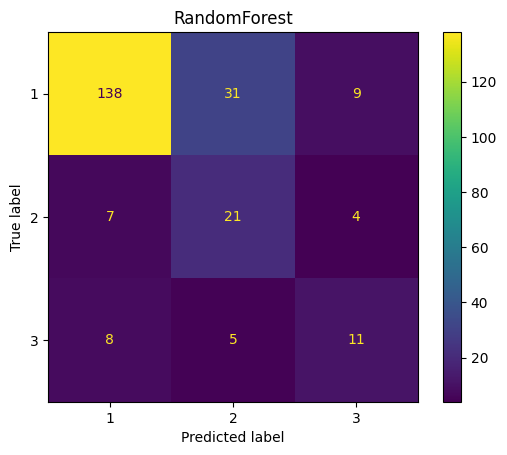

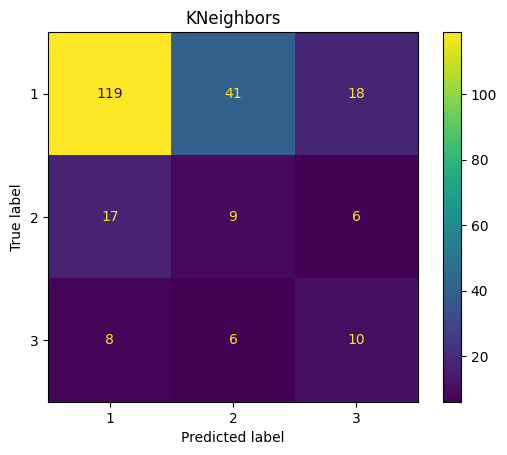

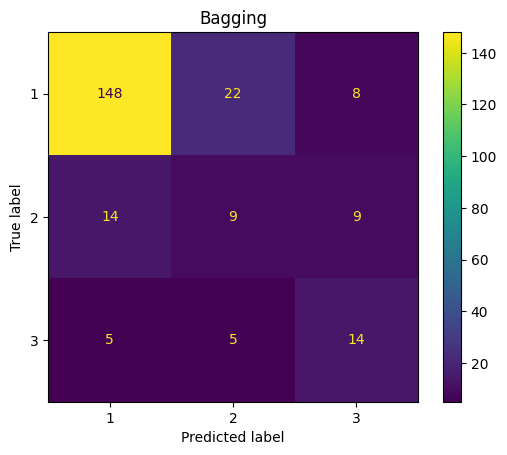

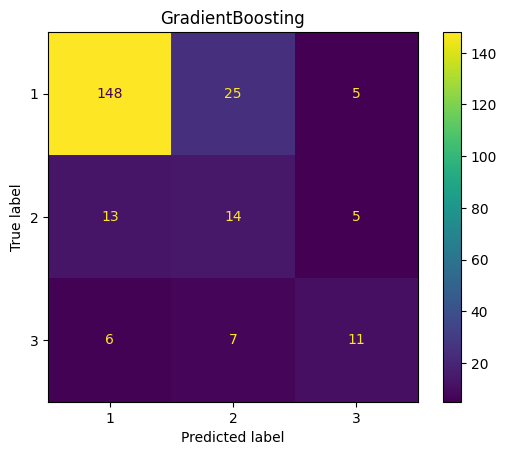

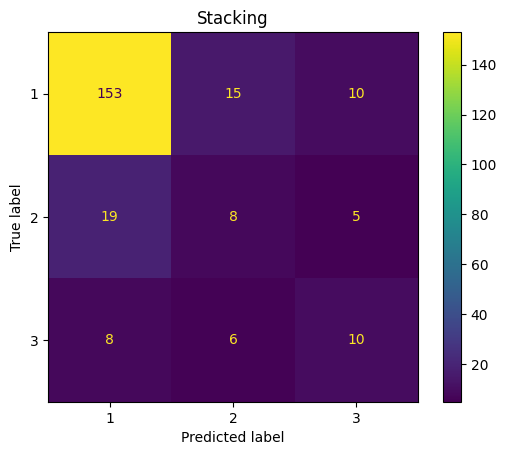

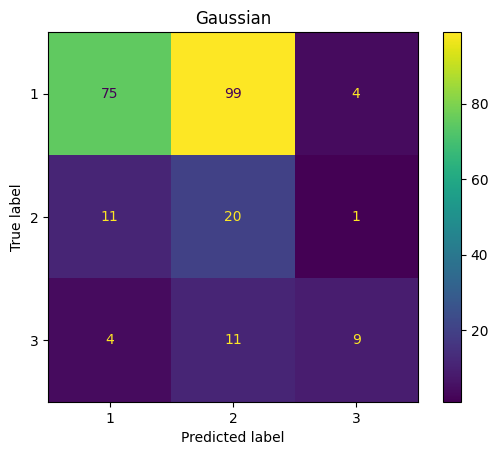

In [29]:
from sklearn import metrics
import matplotlib.pyplot as plt

'''
Here we use confusion matrix to see which classifiers are better.
Our goal is to find what kind of mistakes different models do.
'''

confusion_matrix = metrics.confusion_matrix(test_y.values, predictions)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [1, 2, 3])
cm_display.plot()
cm_display.ax_.set_title("RandomForest")

confusion_m2 = metrics.confusion_matrix(test_y.values, pred_knn)
cm_display2 = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_m2, display_labels = [1, 2, 3])
cm_display2.plot()
cm_display2.ax_.set_title("KNeighbors")

confusion_m3 = metrics.confusion_matrix(test_y.values, pred_bag)
cm_display3 = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_m3, display_labels = [1, 2, 3])
cm_display3.plot()
cm_display3.ax_.set_title("Bagging")

confusion_m4 = metrics.confusion_matrix(test_y.values, pred_gbm)
cm_display4 = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_m4, display_labels = [1, 2, 3])
cm_display4.plot()
cm_display4.ax_.set_title("GradientBoosting")

confusion_m5 = metrics.confusion_matrix(test_y.values, pred_stack)
cm_display5 = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_m5, display_labels = [1, 2, 3])
cm_display5.plot()
cm_display5.ax_.set_title("Stacking")

confusion_m6 = metrics.confusion_matrix(test_y.values, pred_gnb)
cm_display6 = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_m6, display_labels = [1, 2, 3])
cm_display6.plot()
cm_display6.ax_.set_title("Gaussian")

plt.show()

4
0.38461538461538464


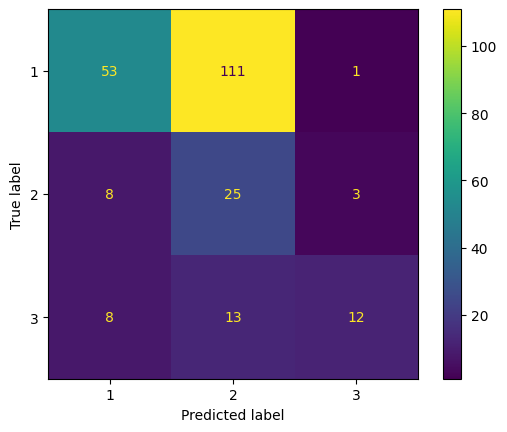

6
0.46153846153846156


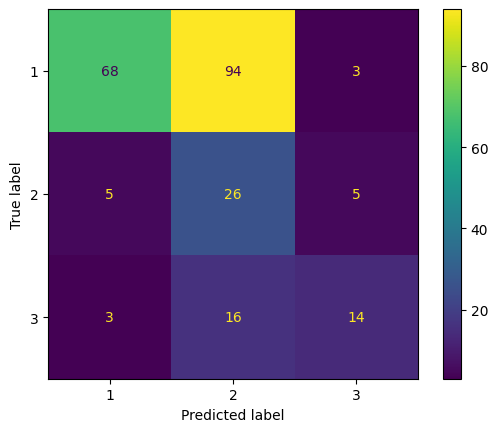

8
0.5299145299145299


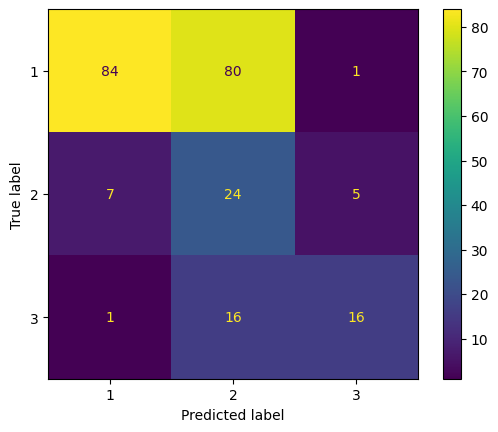

10
0.6623931623931624


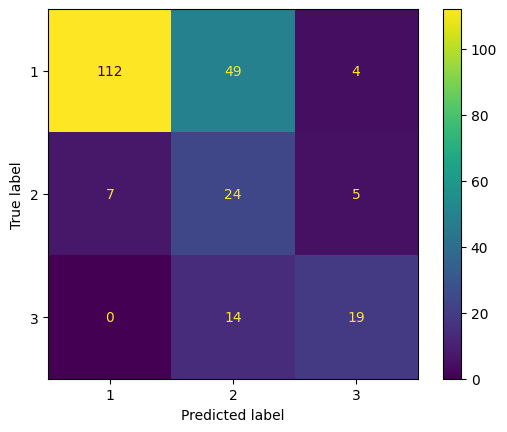

12
0.7051282051282052


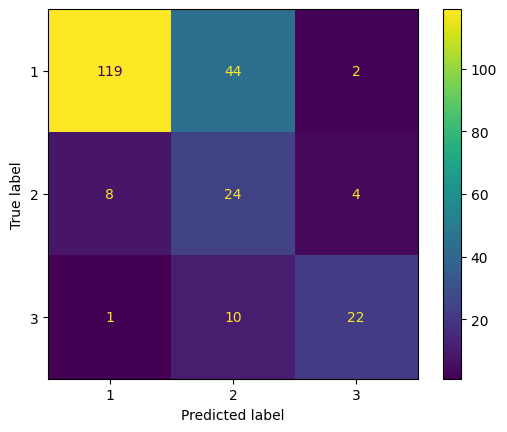

14
0.6965811965811965


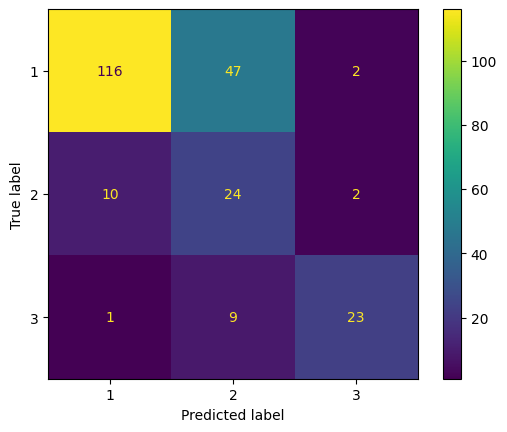

16
0.7435897435897436


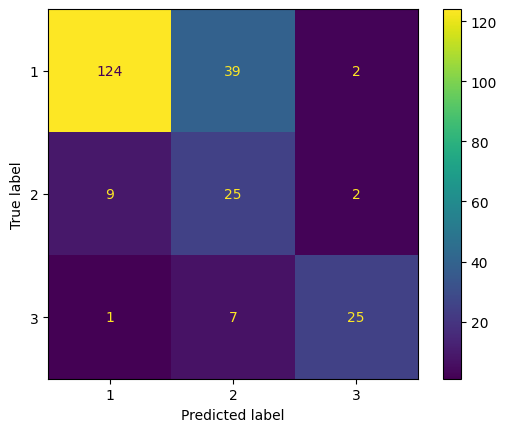

In [50]:
'''
Finally a small loop to see how the results change when using more weeks during model training.
In this part we used GaussianNB model because it gave better and more reasonable results in previous code block.
'''
j=4
while j<=16:
    all_comb = log_comb.merge(data_comb, on='Student')
    all_comb = all_comb.drop('Gender', axis=1)
    all_comb = all_comb.drop('sum_0', axis=1)
    all_comb = all_comb.drop('Grade', axis=1)
    all_comb = all_comb.drop('Student', axis=1)
    all_comb = all_comb.drop('Score', axis=1)
    for i in range(j+1,17):
        homework = 'Week '+str(i)+' homework'
        quiz='Week '+str(i)+' quiz'
        h_score='Week '+str(i)+' homework score'
        q_score='Week '+str(i)+' quiz score'
        if homework in all_comb.columns:
            all_comb = all_comb.drop(homework, axis=1)
            all_comb = all_comb.drop(h_score, axis=1)
        if quiz in all_comb.columns:
            all_comb = all_comb.drop(quiz, axis=1)
            all_comb = all_comb.drop(q_score, axis=1)
    # We are using again under- and oversampling
    tl = TomekLinks()
    ros = SMOTE(random_state=0)
    X_train, X_test, y_train, y_test = train_test_split(all_comb.drop('Category', axis=1), all_comb.Category, test_size=0.3, random_state=42)
    X_resampled, y_resampled = tl.fit_resample(X_train, y_train)
    X_resampled, y_resampled = ros.fit_resample(X_resampled, y_resampled)
    gnb = GaussianNB()
    gnb.fit(X_resampled, y_resampled)
    pred=gnb.predict(X_test)
    print(j)
    print(accuracy_score(pred,y_test.values))
    confusion_matrix = metrics.confusion_matrix(y_test.values, pred)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [1, 2,3])
    cm_display.plot()
    plt.show()
    j+=2